In [ ]:
!nvidia-smi

Fri Jun 23 17:16:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive'

MyDrive


In [ ]:
train_path = '/content/drive/MyDrive/teeth3/train'
test_path = '/content/drive/MyDrive/teeth3/test'
val_path = '/content/drive/MyDrive/teeth3/val'

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, BatchNormalization, Activation, Concatenate
from keras.models import Model
from keras.applications.efficientnet import EfficientNetB0
from keras.applications.efficientnet import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow import keras

import os

import random

import pandas as pd
import seaborn as sns

In [ ]:
class_labels = sorted(os.listdir(train_path))
class_labels

['with_rc', 'without_rc']

In [ ]:
directories = os.listdir(train_path)
sample_image_with_rc = []
sample_image_without_rc = []
class_images = []

for d in directories:
    image_paths = train_path + '/' + d + '/*.jpg'
    image_files = glob(image_paths)
    for i in range(5):
        if d == 'with_rc':
            sample_image_with_rc.append(plt.imread(image_files[random.randint(0, len(image_files) - 1)]))
        else:
            sample_image_without_rc.append(plt.imread(image_files[random.randint(0, len(image_files) - 1)]))
    class_images.append(image_files)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (244, 244)

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(val_path,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_path,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 444 files belonging to 2 classes.
Found 88 files belonging to 2 classes.
Found 95 files belonging to 2 classes.


In [ ]:
class_names = train_dataset.class_names

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
'''data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal')
])'''

"data_augmentation = tf.keras.Sequential([\n  tf.keras.layers.RandomFlip('horizontal')\n])"

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
'''
def receptive_field_block(input_tensor, num_filters):
    branch1 = Conv2D(num_filters, kernel_size=(3, 3), padding='same')(input_tensor)
    branch1 = BatchNormalization()(branch1)
    branch1 = Activation('relu')(branch1)

    branch2 = Conv2D(num_filters, kernel_size=(3, 3), padding='same')(input_tensor)
    branch2 = BatchNormalization()(branch2)
    branch2 = Activation('relu')(branch2)
    branch2 = Conv2D(num_filters, kernel_size=(3, 3), padding='same')(branch2)
    branch2 = BatchNormalization()(branch2)
    branch2 = Activation('relu')(branch2)

    branch3 = Conv2D(num_filters, kernel_size=(3, 3), padding='same')(input_tensor)
    branch3 = BatchNormalization()(branch3)
    branch3 = Activation('relu')(branch3)
    branch3 = Conv2D(num_filters, kernel_size=(3, 3), padding='same')(branch3)
    branch3 = BatchNormalization()(branch3)
    branch3 = Activation('relu')(branch3)
    branch3 = Conv2D(num_filters, kernel_size=(3, 3), padding='same')(branch3)
    branch3 = BatchNormalization()(branch3)
    branch3 = Activation('relu')(branch3)

    concat = Concatenate()([branch1, branch2, branch3])

    return concat'''


inputs = tf.keras.Input(shape=(244, 244, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_______________________________________________

In [ ]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

3/3 [==============================] - 16s 422ms/step - loss: 0.6987 - accuracy: 0.5227
initial loss: 0.70
initial accuracy: 0.52


In [ ]:
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset)

Epoch 1/20
14/14 [==============================] - 13s 274ms/step - loss: 0.7121 - accuracy: 0.4752 - val_loss: 0.6942 - val_accuracy: 0.5341
Epoch 2/20
14/14 [==============================] - 6s 280ms/step - loss: 0.7072 - accuracy: 0.4707 - val_loss: 0.6900 - val_accuracy: 0.5568
Epoch 3/20
14/14 [==============================] - 6s 248ms/step - loss: 0.6959 - accuracy: 0.5090 - val_loss: 0.6871 - val_accuracy: 0.5568
Epoch 4/20
14/14 [==============================] - 6s 211ms/step - loss: 0.6890 - accuracy: 0.5180 - val_loss: 0.6821 - val_accuracy: 0.5568
Epoch 5/20
14/14 [==============================] - 6s 245ms/step - loss: 0.6840 - accuracy: 0.5293 - val_loss: 0.6791 - val_accuracy: 0.5568
Epoch 6/20
14/14 [==============================] - 6s 210ms/step - loss: 0.6967 - accuracy: 0.5023 - val_loss: 0.6757 - val_accuracy: 0.6136
Epoch 7/20
14/14 [==============================] - 6s 223ms/step - loss: 0.6722 - accuracy: 0.5315 - val_loss: 0.6730 - val_accuracy: 0.6136
Epoch

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))
for layer in base_model.layers:
  layer.trainable = True

Number of layers in the base model:  238


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/100),
              metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])

In [ ]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/50
14/14 [==============================] - 46s 557ms/step - loss: 0.6312 - accuracy: 0.6036 - precision: 0.7500 - recall: 0.4180 - val_loss: 0.6636 - val_accuracy: 0.6477 - val_precision: 0.6346 - val_recall: 0.7333
Epoch 21/50
14/14 [==============================] - 8s 344ms/step - loss: 0.6345 - accuracy: 0.5923 - precision: 0.7480 - recall: 0.3893 - val_loss: 0.6639 - val_accuracy: 0.6477 - val_precision: 0.6346 - val_recall: 0.7333
Epoch 22/50
14/14 [==============================] - 8s 367ms/step - loss: 0.6303 - accuracy: 0.6014 - precision: 0.7769 - recall: 0.3852 - val_loss: 0.6645 - val_accuracy: 0.6591 - val_precision: 0.6415 - val_recall: 0.7556
Epoch 23/50
14/14 [==============================] - 8s 357ms/step - loss: 0.6196 - accuracy: 0.6284 - precision: 0.7801 - recall: 0.4508 - val_loss: 0.6646 - val_accuracy: 0.6591 - val_precision: 0.6364 - val_recall: 0.7778
Epoch 24/50
14/14 [==============================] - 8s 344ms/step - loss: 0.6152 - accuracy: 0.619

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

3/3 [==============================] - 8s 502ms/step - loss: 0.5261 - accuracy: 0.8526 - precision: 0.9130 - recall: 0.8077


ValueError: ignored

Predictions:
 [1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1]
Labels:
 [0 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1]


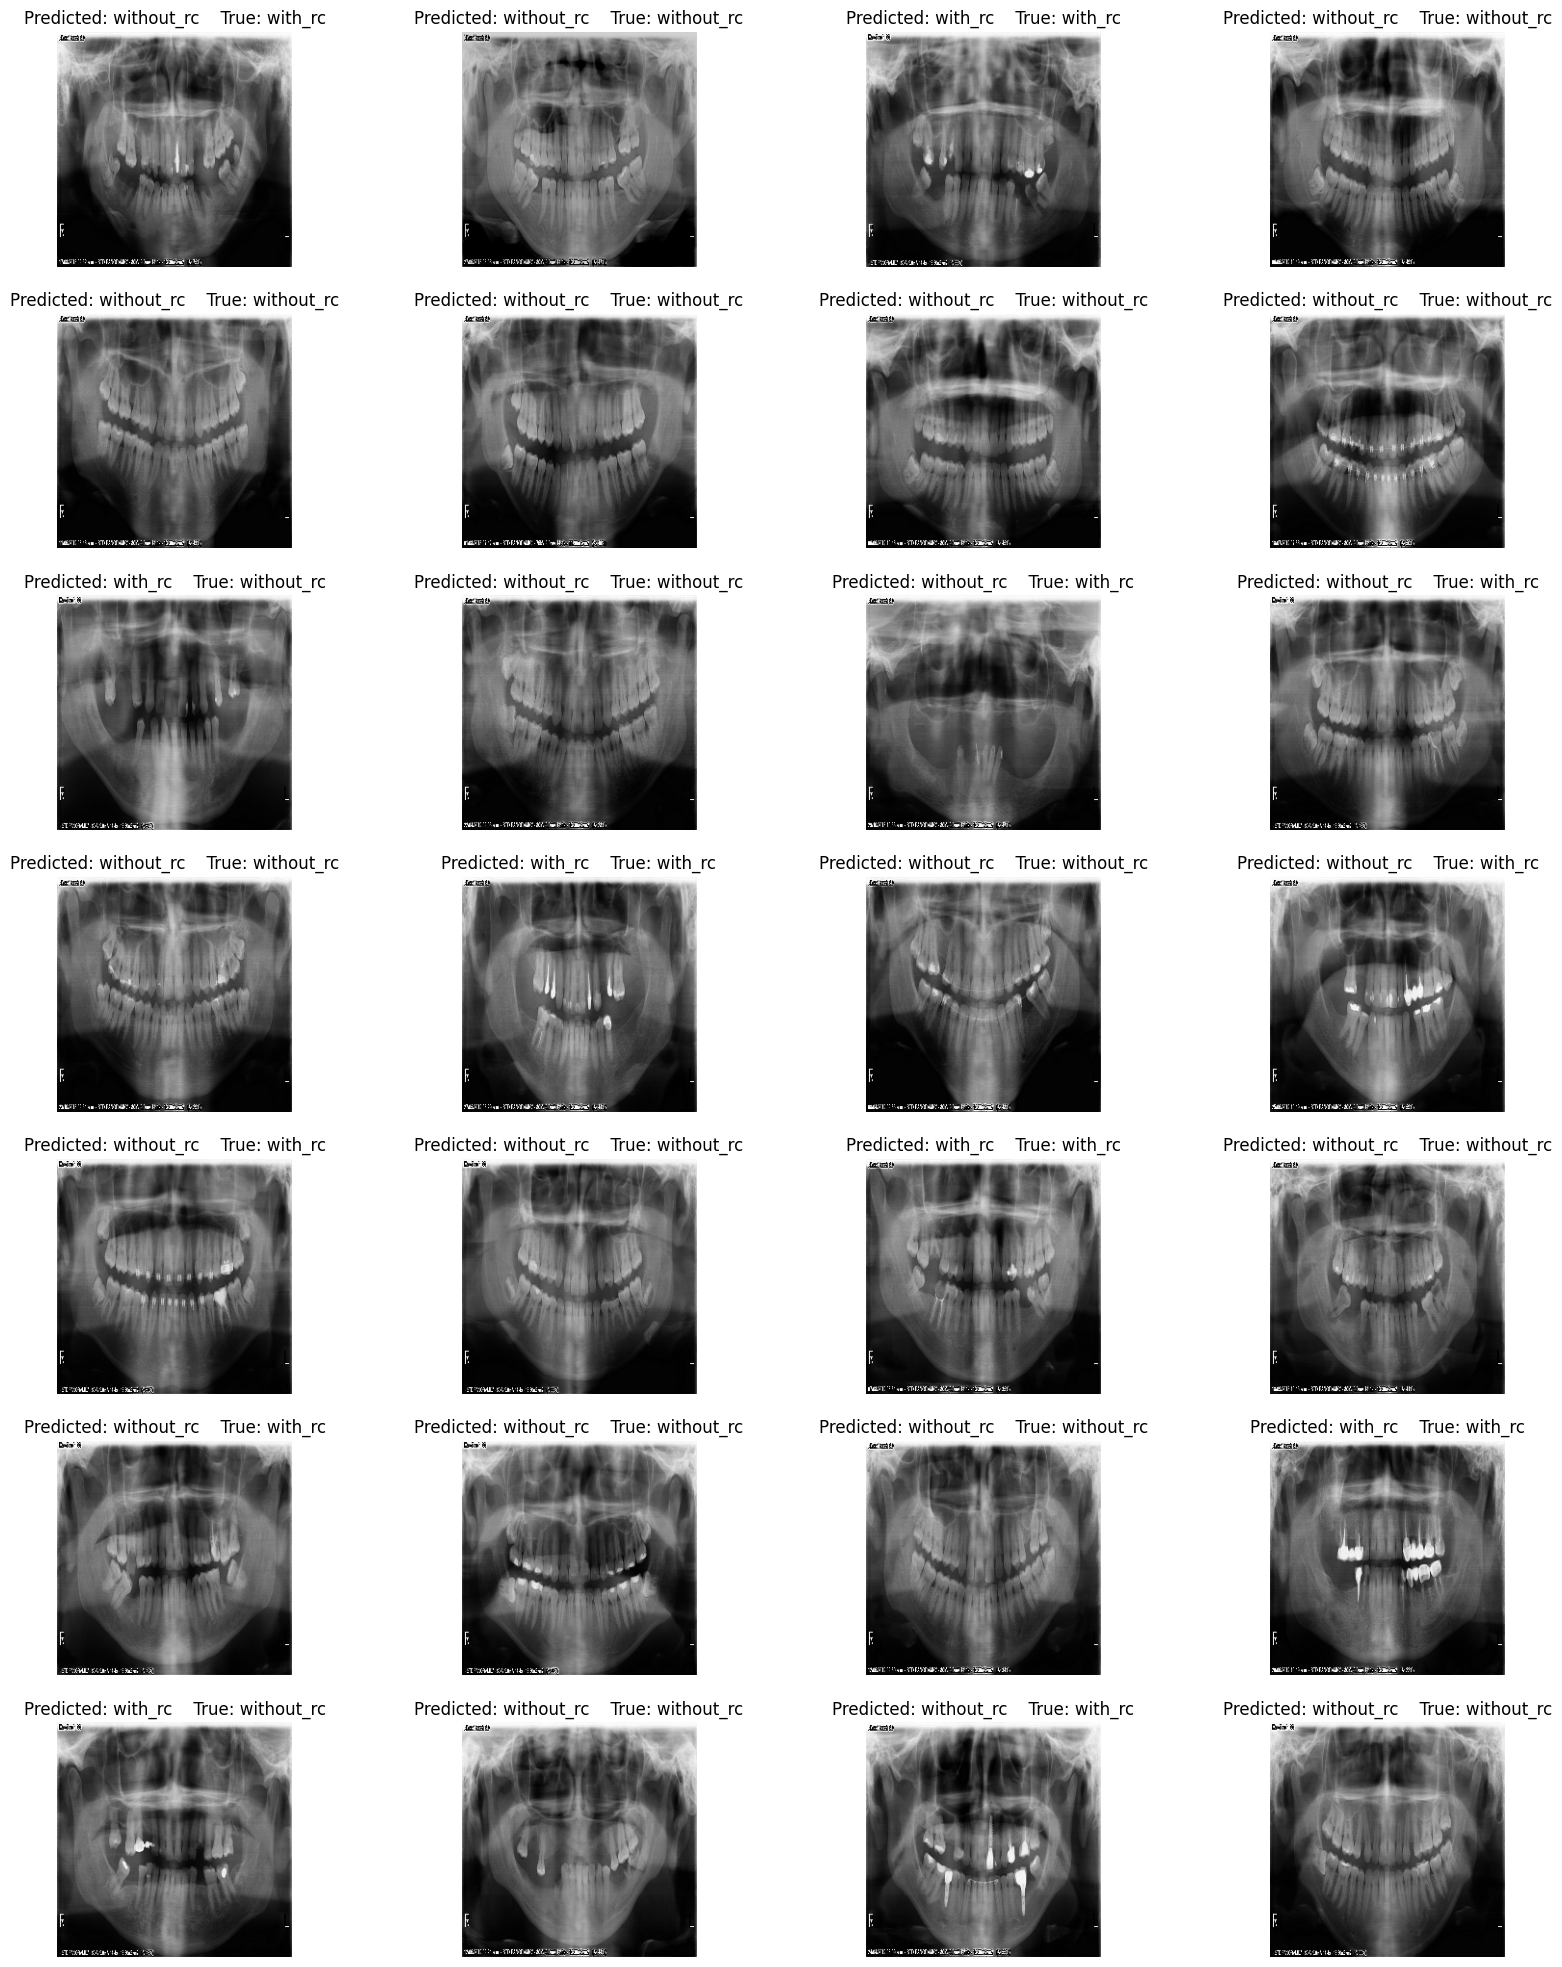

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(20, 25))
for i in range(28):
  ax = plt.subplot(7, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title('Predicted: '+ class_names[predictions[i]] + '    True: ' + class_names[label_batch[i]])
  plt.axis("off")

In [ ]:
model.save('efficientnetb0.h5')

TypeError: ignored

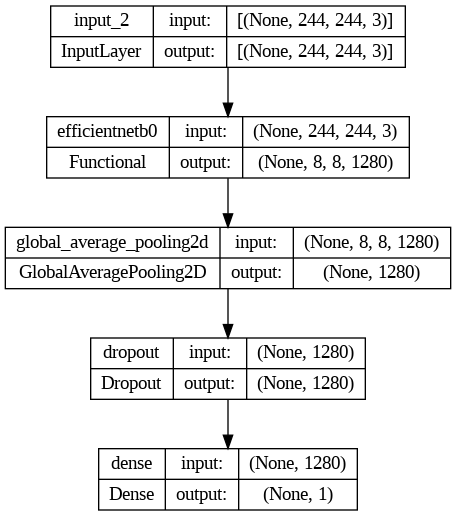

In [ ]:
from tensorflow import keras
keras.utils.plot_model(model, "model.png", show_shapes=True)

In [ ]:
predict = np.array([])
l =  np.array([])
for x, y in test_dataset:
  p = model.predict(x).flatten()
  p = tf.nn.sigmoid(p)
  p = tf.where(p < 0.5, 0, 1)
  predict = np.concatenate([predict, p])
  l = np.concatenate([l, y])

1/1 [==============================] - 1s 1s/step


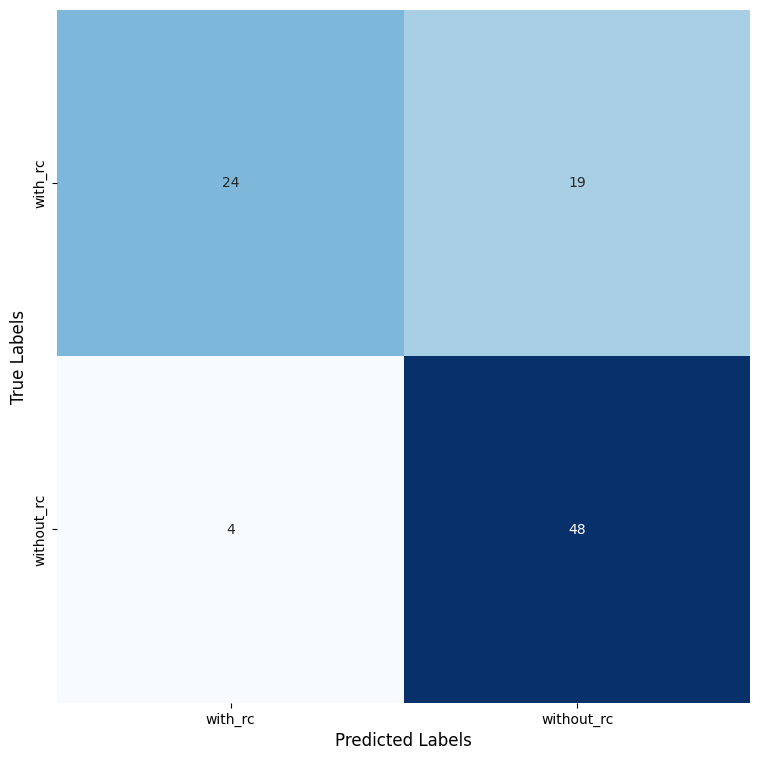

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(l, predict)

plt.figure(figsize=(10,9))
sns.heatmap(cm, annot=True, square=True, xticklabels=class_names, yticklabels=class_names, fmt='d',
           cmap=plt.cm.Blues, cbar=False)
plt.ylabel('True Labels', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=12)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Classification Report
report = classification_report(l, predict, target_names=class_names)
print(report)

              precision    recall  f1-score   support

     with_rc       0.86      0.56      0.68        43
  without_rc       0.72      0.92      0.81        52

    accuracy                           0.76        95
   macro avg       0.79      0.74      0.74        95
weighted avg       0.78      0.76      0.75        95



In [ ]:
# Calculate specificity
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
print("Specificity:", specificity)

Specificity: 0.5581395348837209
